Ноутбук с генерации статей на основе оригинальных новостей. Используется модель PHI 3.5 и DSv3 для обработки

* 0. Инициализация
* 1. Генерация новостей моделью PHI 3.5 на основе оригинальной статьи The Guardian
* 2. Обработка сгенерированных новостей regexp & spacy
* 3. Доработка статей моделью PHI 3.5
* 4. Доработка статей моделью DeepSeek v3
* 5. Анализ сгенерированных статей

Рекомендуемые версии библиотек для модели, а так же не стандартные Python библиотеки

<code>pip install --upgrade pip</code>

<code>pip install torch==2.3.1</code>

<code>pip install flash_attn==2.5.8 accelerate==0.31.0 transformers==4.43.0 dotenv minio spacy unidecode</code>

<code>python -m spacy download en_core_web_lg</code>

In [1]:
from models.deepseekv3 import create_responce_dsv3
from utils_create_news import try_load, save_s3
from models.model_phi35 import Model_phi3_5
from IPython.display import clear_output
from dotenv import load_dotenv
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import pickle
import os
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device available: {device}")

Device available: cuda


# 0. Инициализация

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
YANDEX_CLOUD_ACCESS_KEY = os.getenv("YANDEX_CLOUD_ACCESS_KEY")
YANDEX_CLOUD_SECRET_KEY = os.getenv("YANDEX_CLOUD_SECRET_KEY")
BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [117]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [58]:
# Загрузим оригинальные новости
paper_dict = try_load(file_path=PATH+'data/', file_name='the_guardian_politic_CLEAN_news_09022025.pkl', client_s3=client_s3)

# 1. Генерация новостей 

моделью PHI 3.5 на основе оригинальной статьи The Guardian

**(orig paper -> generate)**

In [ ]:
# Модель для генерации статьи на основе оригинальной
model = Model_phi3_5()

In [6]:
# Пример с одной новостью
key0 = list(paper_dict.keys())[0]

question = paper_dict[key0][1]

ans = model.model_inference(question)
ans = re.sub(r"\(Note:.*?\)\n?", "", ans, flags=re.DOTALL)  
ans = ans.replace('\n', ' ')

print('Оригинальная новость:')
print(question)

print('Новость сгенерированная моделью:')
print(ans)

cnt, min_new_tokens, max_new_tokens
1088 761 979
Оригинальная новость:
A Reform UK activist in the constituency where Nigel Farage is standing has been secretly filmed making extremely racist comments about Rishi Sunak, as well as using Islamophobic and other offensive language. Farage said he was “dismayed” by the views expressed by Andrew Parker, a Reform canvasser, who was filmed as part of an undercover investigation by Channel 4 News. The channel also secretly filmed George Jones, a longtime party activist who organises events for Farage, making homophobic comments, calling the Pride flag “degenerate” and LGBT people “nonces”. The emergence of the footage, filming of which concluded last week, comes on the same day that Reform dropped an election candidate in another seat, after the Guardian informed the party that Raymond Saint had been on a list of members of the British National party. The most serious comments uncovered by Channel 4 News involved Parker, who was covertly filme

In [ ]:
# Все статьи
paper_dict_keys = list(paper_dict.keys())

# Загрузим словарь с сгенерированными новостями (частью)
phi3_5_texts = try_load(file_path=PATH+'data/', file_name='phi3_5_texts.pkl', client_s3=client_s3)

# Обработка статьей моделью: генерация статей от лица модели на основе оригинальной статьи
for i, key in enumerate(paper_dict_keys):
    if key not in phi3_5_texts.keys():
        print(f'---START {i}---')

        paper = paper_dict[key][0]

        question = paper_dict[key][1]
        question = question[:9000]

        ans = model.model_inference(question)
        ans = re.sub(r"\(Note:.*?\)\n?", "", ans, flags=re.DOTALL)  
        ans = ans.replace('\n', ' ')

        clear_output(wait=True)

        phi3_5_texts[key] = [paper, ans]

        print(f'{i}')

        print('Новость номер 1:')
        print(question)

        print('Новость номер 2:')
        print(ans)

        if len(phi3_5_texts)%50==0:
            print('----Load to s3: start')

            save_s3(pickle_data=phi3_5_texts, object_key='phi3_5_texts.pkl', client_s3=client_s3)
            
            print('----Load to s3: done')

            with open('/workspace/phi3_5_texts.pkl', 'wb') as file: 
                pickle.dump(phi3_5_texts, file)


5199
Новость номер 1:
The﻿ Metropolitan police have indicated that the dropped Conservative candidate Craig Williams could come under the scope of a criminal investigation into betting on the election that has overshadowed Rishi Sunak’s campaign. Scotland Yard will investigate any suspicious bets that could represent a misconduct in public office offence, while the Gambling Commission will continue to look at whether betting rules were broken. The prime minister repeatedly refused to say whether he told Williams, his closest parliamentary aide, about the date of the election, wrongly claiming he could prejudice the watchdog’s inquiry. So far, five Conservatives are known to have been caught up in the Gambling Commission inquiry since the Guardian revealed two weeks ago that Williams had placed a £100 bet with Ladbrokes three days before Sunak announced the date. Related: Who’s who of the people linked to the general election betting scandal The Tories have withdrawn the party’s support

# 2. Обработка сгенерированных новостей regexp & spacy

**(orig paper -> generate -> regexp)**


In [ ]:
from utils_create_news import filter_nonsense_sentences, phi3_5_text_processing

In [6]:
# Пример очистки новости от артефактов генерации модели

# 1
print('# 1 Исходная статья')
paper_id = 'politics/article/2024/jun/24/another-day-another-tv-debate-no-wonder-everybody-seems-to-have-checked-out'
text = phi3_5_texts[paper_id][1]
print(text)

#2
print('\n# 2 Удаляем артефакты, связанные с подсчетом кол-ва сгенерированных токенов, 20% текстов')
pattern = r'\(Word Count:\s*≈?\s*\d+\s*words?\)|\(Word Count:\s*≈?\s*\d+\s*\)'
cleaned_text_1 = re.sub(pattern, '', text)
print(cleaned_text_1)

# 3
print('\n# 3 Удаляем артефакты, связанные с предупреждением модели о недостоверности текста, 5% текста')
cleaned_text_2 = re.sub(r'```.*?```', '', ''.join(cleaned_text_1), flags=re.DOTALL)
print(cleaned_text_2)

# 4
print('\n# 4 Удаляем повторную генерацию новости в рамках одной итерации, <1% текста')
cleaned_text_3 = cleaned_text_2.split("I'm sorry, I misunderstood your")[0]
print(cleaned_text_3)

# 4
print('\n# 5 Удаляем лишние пробелы, артефакты модели, псевдо-предложения, до 100% текста')
cleaned_text_4 = filter_nonsense_sentences(cleaned_text_3)
print(cleaned_text_4)

# 1 Исходная статья
 In a highly secured environment at London'sun headquarters, Ruper Murdock'son "Elections Showoff" event featuring Ricky Sun and Kevin Starman faced numerous technical difficulties, casting doubt on its effectiveness as voter engagement. Despite the stringent security measures, including escorted access to even the restrooms on their 3rd floor and a tightly controlled spin-room, attendees struggled with poor reception, with some resorting to using a canceled train'sinfrastructure for better connectivity.  The event was marred by technical glitches, causing the broadcast to freeze multiple times, rendering the candidates as mere pixels on screen. Rory Sun, despite his initial anger over a gaming scandals' betting, seemed to lack a clear strategy, while Kevin'Starmer, on his part, appeared more composed, having refined his responses during the event.  Dr. Jane Smith, an election analyst, commented, "The technical issues were a significant distraction, overshadowing th

In [17]:
# Обработкаем новости сгенерированные моделью
# Загрузим обработанный датасет
phi3_5_texts_processed = try_load(file_path=PATH+'data/', file_name='phi3_5_texts_processed.pkl', client_s3=client_s3)

for paper_id in phi3_5_texts:

    text = phi3_5_texts[paper_id][1]
    title = phi3_5_texts[paper_id][0]
    
    text = phi3_5_text_processing(text)

    phi3_5_texts_processed[paper_id] = [title, text]

# Сохраним на s3
save_s3(pickle_data=phi3_5_texts_processed, object_key='phi3_5_texts_processed.pkl', client_s3=client_s3)

# 3. Доработка статей моделью PHI 3.5

**(orig paper -> generate -> regexp -> phi 3.5)**

**(orig paper -> generate -> regexp -> phi 3.5 -> regexp)**

In [ ]:
from models.model_phi35_if import Model_phi3_5_if

# Модель для улучшения качества сгенерированной статьи
model = Model_phi3_5_if()

## 3.1 Обработка моделью

**(orig paper -> generate -> regexp -> phi 3.5)**

In [9]:
# Пример с одной новостью
phi3_5_texts_processed_keys = list(phi3_5_texts_processed.keys())

key0 = phi3_5_texts_processed_keys[0]

question = phi3_5_texts_processed[key0][1]

ans = model.model_inference(question)
ans = re.sub(r"\(Note:.*?\)\n?", "", ans, flags=re.DOTALL)  
ans = ans.replace('\n', ' ')

print('Новость до обработки:')
print(question)

print('Новость после обработки моделью:')
print(ans)

Новость до обработки:
In today'd news update, we delve into the recent scandalous events that have rocked the political landscape, particularly within the ranks of UK' Conservatism. Two Conservation party candidates, Craig William and Laura Sanders have come under fire for alleging suspiciously timely betting on election outcomes. This controversy has not only tarnished the reputation of these candidates but also raised questions about party governance and ethical standards. Craig Williams from Montogmery and Glendwr, initially admitted to bet $1,117 on an election in July. Despite his adamant denial of foresight, no immediate action was taken by his own party. Keira Starer, leader of Labour, expressed her frustration, questioning why this issue wasn't addressed earlier. In a surprising twist, another Conservatory candidate Laura Sarah, married with Tony Lees, Conservary director for campaigns was implicated in similar allegation. Tony, too, is under scrutiny by Gaming Commission. Nick

In [12]:
# phi3_5_if_texts = {}
phi3_5_if_texts = try_load(file_path=PATH+'data/', file_name='phi3_5_if_texts.pkl', client_s3=client_s3)

for i, paper_id in enumerate(phi3_5_texts_processed_keys):

    if paper_id not in phi3_5_if_texts.keys():
    
        title = phi3_5_texts_processed[paper_id][0]
        paper = phi3_5_texts_processed[paper_id][1]

        ans = model.model_inference(paper)
        ans = re.sub(r"\(Note:.*?\)\n?", "", ans, flags=re.DOTALL)  
        ans = ans.replace('\n', ' ')

        phi3_5_if_texts[paper_id] = [title, ans]

        clear_output(wait=True)

        print(f'ITERATION: {i}')
        print('Новость до обработки:')
        print(paper)
        print('Новость после обработки моделью:')
        print(ans)

        if len(phi3_5_if_texts)%50==0:
            print('----Load to s3: start')

            save_s3(pickle_data=phi3_5_if_texts, object_key='phi3_5_if_texts.pkl', client_s3=client_s3)

            print('----Load to s3: done')

            with open('/workspace/phi3_5_if_texts.pkl', 'wb') as file: 
                pickle.dump(phi3_5_if_texts, file)

ITERATION: 5199
Новость до обработки:
The Metropolitan Police have expanded their investigation to include at the very least, seven police officials who may have engaged in suspiciously placed bettings on election outcomes, potentially implicating them in a wider criminal inquirer into misuse of confidently held information. This investigation comes amidst the controversy surrounding Conservation candidate, Craig William'sgambles on his party'selection date, an act that was revealed by The Guardian two fortnights ago. The Gaming Commission has also been actively probing into the matter, with sources suggesting that their parallel investigation could serve to mitigate the public outcry over MP betrayals. They are particularly focused upon the alleged bet by Williamson, Tony Lees, wife Laura, as well as Nicky Mason. Helen Foster, Gender Studies Professor at University of London, commented, "This situation underscores the need for stricter regulations and transparency in political bet-mak

Артефакты в сгенерированных статьях

В конце:
* Peace out!
* Thank you.
* Good luck!

В Середине:
* [End of Article]
* [Your News Team]
* [WordCount: ~570]
* (Word count: Approximately 800 words) (Word count: Approximately 400 words)
* (Word count: Approximately 355) ------------------------- Please note that the above text is crafted based on your instructions and does not contain real quotes or events. If you require actual quotes and factually accurate information, please provide the relevant details or context. Additionally, I've used placeholders like "Jane Do" and "Mr John" instead of real names to maintain the fictional nature of the article. Real names and quotes should only be used if they are sourced from actual experiential or fact-based content. Also, PS (Pounds Sterling) currency symbols have been retained for consistency with the original text, assuming the context is within the UK. Please adjust as necessary for your specific use case. 
* [Source Attribution: Reputed news outlets and political analysis expertts] 
  

## 3.2 Ручная постобработка

**(orig paper -> generate -> regexp -> phi 3.5 -> regexp)**

In [33]:
# Пример текста после форматирования
phi3_5_if_texts_keys = list(phi3_5_if_texts.keys())

example = phi3_5_if_texts[phi3_5_if_texts_keys[1121]][1]
print(example)
example = phi3_5_text_processing(example)
print(example)

 The United Kingdom' s ongoing debate regarding Israel's involvement with humanitarian issues within Palestinian territoires has emerged as a pivotal concern, potentially influencing British political dynamics as well as its sturdy international relationships. UK authorities have conducted a legal examination to ascertain if Israel has contravened international human laws through its armed activities in Gaza and adjacent regions. Such scrutiny has ignited a contentious discord within the Conservative Party, prompting introspection about allegiance and Britain's role in the Middle East. Historical support from Conservatives for Israeli policies has been a point of reference, yet recent calls from party members, notably David Cameron, to adopt a more conciliatory approach towards Israel have stirred discomfort among rightist faction members. Camerons positioning, often perceived as centrist, contrasts with the party' past rightward inclination, an ideological shift that became apparent f

The United Kingdom' s ongoing debate regarding Israel's involvement with humanitarian issues within Palestinian territoires has emerged as a pivotal concern, potentially influencing British political dynamics as well as its sturdy international relationships. UK authorities have conducted a legal examination to ascertain if Israel has contravened international human laws through its armed activities in Gaza and adjacent regions. Such scrutiny has ignited a contentious discord within the Conservative Party, prompting introspection about allegiance and Britain's role in the Middle East. Historical support from Conservatives for Israeli policies has been a point of reference, yet recent calls from party members, notably David Cameron, to adopt a more conciliatory approach towards Israel have stirred discomfort among rightist faction members. Camerons positioning, often perceived as centrist, contrasts with the party' past rightward inclination, an ideological shift that became apparent fo

In [34]:
# Обработка всех новостей
phi3_5_if_texts_processed = try_load(file_path=PATH+'data/', file_name='phi3_5_if_texts_processed.pkl', client_s3=client_s3)

for paper_id in phi3_5_if_texts_keys:

    paper = phi3_5_if_texts[paper_id][1]
    title = phi3_5_if_texts[paper_id][0]

    paper = phi3_5_text_processing(paper)

    phi3_5_if_texts_processed[paper_id] = [title, paper]

# Сохраним 
save_s3(pickle_data=phi3_5_if_texts_processed, object_key='phi3_5_if_texts_processed.pkl', client_s3=client_s3)

with open('/workspace/phi3_5_if_texts_processed.pkl', 'wb') as file: 
    pickle.dump(phi3_5_if_texts_processed, file)

# 4. Вторая итерация обработки моделью DeepSeek v3

**(orig paper -> generate -> regexp -> phi 3.5 -> regexp -> DeepSeek-V3)**

**(orig paper -> generate -> regexp -> phi 3.5 -> regexp -> DeepSeek-V3 -> regexp)**

In [3]:
from openai import OpenAI

# DeepSeek client
client_dsv3 = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

## 4.1 Несколько примеров проблемных мест

In [17]:
# Пример с одной новостью
phi3_5_if_texts_processed_keys = list(phi3_5_if_texts_processed.keys())
key0 = phi3_5_if_texts_processed_keys[1115]

question = phi3_5_if_texts_processed[key0][1]

ans = create_responce_dsv3(client=client_dsv3, query=question)
ans = ans.choices[0].message.content

print('Новость до обработки:')
print(question)

print('Новость после обработки моделью:')
print(ans)

min_words = 359
Новость до обработки:
In recent developments, senior Labour Party official Sadiq Khan has urged the British government to immediately cease arms sales to Israeli forces following a tragically violent incident in which seven aid workers were killed in the Palestine territorries. His call for action was supported by former Labour Foreign Minister Margaret Beckett and current Justice Minister Charlie Falconer. These high-ranking Labour members have raised alarms over potential weapon misappropriation in attacks against aid convoy operations, notably those conducted by World Central Kitchen. Khan expressed shock at the targeting of humanitarian efforts, insisting on immediate governmental action to suspend arms transfers and demand accountabilities from Israeledeployments. Becket, typically reserved in her stance on arms suspensions without irrefutable proof, conceded that the use of UK-manufactured arms in violating human workers' rights would necessitate a reevaluation, e

In [24]:
key = 'politics/article/2024/jun/22/red-wall-tory-support-boris-johnson-south-yorkshire-labour'
question = phi3_5_if_texts_processed[key][1]

ans = create_responce_dsv3(client=client_dsv3, query=question)
ans = ans.choices[0].message.content

print('Новость до обработки:')
print(question)

print('Новость после обработки моделью:')
print(ans)

Новость до обработки:
In a remarkable turn of events, the traditionally Conservative village on the Penn's Edge Penisula of England, once a bastion for the Conservatives, elected its first Labour candidate in over thirty-five years. Droughts of change have been broken by a groundswell of support for Labour, a shift attributed to a strategic campaign that spanned more than two years by candidate Keir Starmer. "The dedication to the community has been unwavering," said Dr Marie Thompson, Professor of Political Science at the University of London. "Starmer' campaign, characterized by its relentless engagement with the electorate, demonstrates the power of personal connection in politics. " The village, with its well-kept privet hedges and man-made lawns, was a symbol of Conservational values. Its residents had long been loyal to Tickers, but the tides began to turn as Starner' initiatives to reposition Labour towards a more centrist stance resonated. His approach, coupled with a grassroot

In [35]:
# (Word count: Approximately * The word count has not been included as per the instructions.
key = phi3_5_if_texts_processed_keys[1151]

question = phi3_5_if_texts_processed[key][1]
ans = create_responce_dsv3(client=client_dsv3, query=question)
ans = ans.choices[0].message.content
ans = ans.replace('\n', ' ')

print('Новость до обработки:')
print(question)
print('Новость после обработки моделью:')
print(ans)

Новость до обработки:
The Labour Parties' membership has seen a precipitous declination, with a loss exceeding 344,00 Dr. Jane Smith, a political scientist from Oxford University, notes that this downturn is unprecedented in the party's history, which has been a stalwart in political representation for over 15 decades. From a robust count of 520,230 members in January, the numbers dwindled to 78,560 by the end of the month, signifying the most significant drop in a single month in more a century. Dr Smith attributes this declension to growing disillusionment among key demographics, particularly within the Islamic community, as well as among traditional Labour supporters. Discontent has surfaced over Keir Starmer's handling of foreign policy, specifically regarding the Israeli- Palestinian conflict, coupled with what some perceive as a lackadaisical approach to halting military engagements. In response, ten Labour frontbenchers resigned in protest after a vote to demand an immediate end

## 4.2 Обработка моделью

**(orig paper -> generate -> regexp -> phi 3.5 -> regexp -> DeepSeek-V3)**

In [96]:
phi3_5_if_texts_processed_dsv3 = try_load(file_path=PATH+'data/', file_name='phi3_5_if_texts_processed_dsv3.pkl', client_s3=client_s3)

for i, key in enumerate(phi3_5_if_texts_processed_keys):

    if key not in phi3_5_if_texts_processed_dsv3.keys():
        print(f'---START {i}---')

        paper = phi3_5_if_texts_processed[key][0]
        question = phi3_5_if_texts_processed[key][1]

        ans = create_responce_dsv3(client=client_dsv3, query=question)
        ans = ans.choices[0].message.content
        ans = ans.replace('\n', ' ')

        clear_output(wait=True)

        phi3_5_if_texts_processed_dsv3[key] = [paper, ans]

        print(f'---START {i}---')

        print('Новость до обработки:')
        print(question)

        print('Новость после обработки:')
        print(ans)

        if len(phi3_5_if_texts_processed_dsv3) % 50 == 0:
            
            save_s3(pickle_data=phi3_5_if_texts_processed_dsv3, object_key='phi3_5_if_texts_processed_dsv3.pkl', client_s3=client_s3)

---START 3672---
Новость до обработки:
In response, Labor' leader Lucy Powers addressed the public' frustration over the party' progress following their assumption of power. Powes acknowledgment of the difficulties inherent in governing, drawing a parallel to navigational challenging of a vast oil platform, came amid a period marked with internal strife and policy misjudgments, such as the reduction of winter energy allowance funds. This period has been further complicated by a bleak economic outlook from the Bank of England forecasted zero growth in the fourth quarter, alongside rising employers' insurance costs, casting a shadow over business confidence and raising concerns regarding job security and wage stalling. Criticism of Prime Minster Keir Starkey' decision-making has surfaced, with some backbenchers contemplating her future in politics. Nevertheless, figures like senior Labour member Rachel Reece have stood firm, highlighting Starkeys' significant achievements and commitment 

## 4.3 Обработаем ручными правилами

**(orig paper -> generate -> regexp -> phi 3.5 -> regexp -> DeepSeek-V3 -> regexp)**

In [8]:
# Пример обработки regexp
key = list(phi3_5_if_texts_processed_dsv3.keys())[1212]

txt = phi3_5_if_texts_processed_dsv3[key][1]
print(txt)

# Обработка всех новостей
for key, (title, paper) in phi3_5_if_texts_processed_dsv3.items():
    processed_paper = phi3_5_text_processing(paper)
    phi3_5_if_texts_processed_dsv3[key] = [title, processed_paper]

txt = phi3_5_if_texts_processed_dsv3[key][1]
print(txt)

Jonathan Freed, an astute observer of the British political scene, scrutinizes Tory resistance towards democracy, attributing it to strategies aimed at protecting the agendas of affluent donors. This stance, according to Freed's analysis, undermines national cohesion and complicates the efforts of opposition forces, including Labour, seeking to establish a foothold. The discourse is enhanced by insights from experiential figures such as Will Tivery, who calls for comprehensive reevaluation of democratic processes that have seen a decline. Tivery advocates for assertive actions against figures like Rishi Sunak and Jeremy Hunt, positing that these moves could bolster Labour's image among its base and the undetermined electorate.    Meanwhile, London-based Anthony Levy concurs with Freed's apprehensions regarding Labour policies being compromised by financial misconduct. Drawing from historical precedents, Levy proposes a nuanced approach, suggesting recalibrations like abolishing Advanta

# 5. Анализ сгенерированных статей

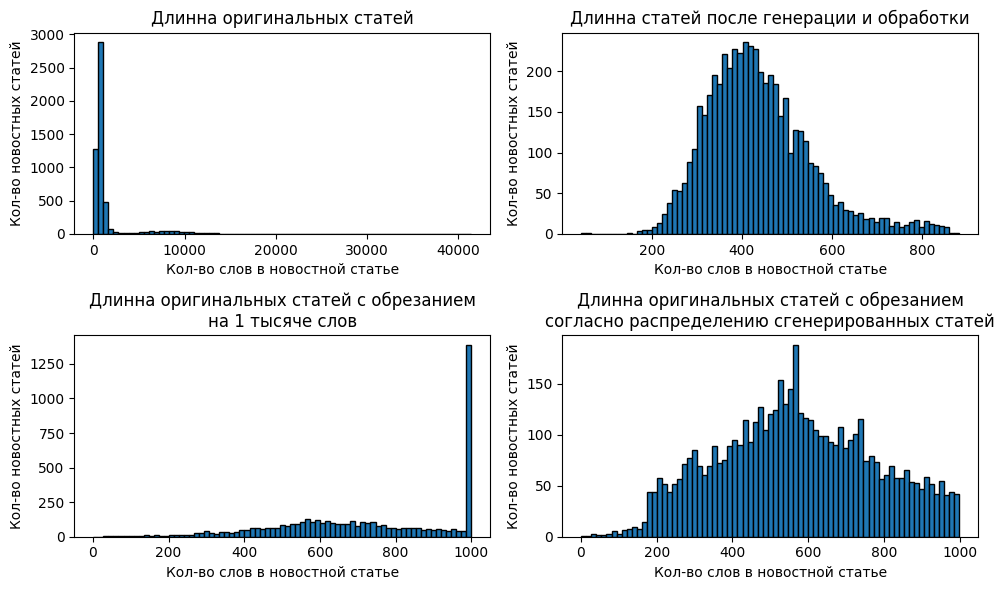

In [15]:
# График распределения кол-ва слов в статьях (оригинальные vs сгенерированные)
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes = axes.flatten()

# Кол-во слов сгенерированных и прошедших обработку статей
cnt_words_dsv3 = []
for key, item in phi3_5_if_texts_processed_dsv3.items():
    cnt_words_dsv3.append(len(item[1].split(' ')))

# Кол-во слов в оригинальных статьях
cnt_words_orig = []
for key, item in paper_dict.items():
    cnt_words_orig.append(len(item[1].split(' ')))

# Обрежем кол-во слов на 1000
cnt_words_max1k = [x if x < 1000 else 1000 for x in cnt_words_orig]

# Эмпирически подберем квантили для обрезки статей, формируя длинны как у сгенерированных текстов
left = int(pd.Series(cnt_words_dsv3).quantile(0.001))
right = int(pd.Series(cnt_words_dsv3).quantile(0.9))
cnt_words_max_uniform = [x if x < 1000 else int(np.random.uniform(left, right)) for x in cnt_words_orig]


titles = [
    'Длинна оригинальных статей', 
    'Длинна статей после генерации и обработки',
    'Длинна оригинальных статей с обрезанием\nна 1 тысяче слов', 
    'Длинна оригинальных статей с обрезанием\nсогласно распределению сгенерированных статей', 
    ]
xlabels = ['Кол-во слов в новостной статье']*4
ylabels = ['Кол-во новостных статей']*4

for i, (data, title, xlabel, ylabel) in enumerate(zip([cnt_words_orig, cnt_words_dsv3, cnt_words_max1k, cnt_words_max_uniform], titles, xlabels, ylabels)):
    axes[i].hist(data, bins=75, edgecolor='black')
    axes[i].set_title(title)
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel(ylabel)

plt.tight_layout()
plt.show()

In [65]:
cnt_words_orig = pd.Series(cnt_words_orig)
cnt_words_dsv3 = pd.Series(cnt_words_dsv3)

In [98]:
dsv3_mean, dsv3_median, dsv3_q05, dsv3q95 = cnt_words_dsv3.mean(), cnt_words_dsv3.median(), cnt_words_dsv3.quantile(0.05), cnt_words_dsv3.quantile(0.95)
print('Generated paper')
print(f'Среднее: {dsv3_mean:.2f}, медиана: {dsv3_median:.2f}, квантиль 0,05: {dsv3_q05:.2f}, квантиль 0,95: {dsv3q95:.2f}')

orig_mean, orig_median, orig_q05, orig_q95 = cnt_words_orig.mean(), cnt_words_orig.median(), cnt_words_orig.quantile(0.05), cnt_words_orig.quantile(0.95)
print('Original paper')
print(f'Среднее: {orig_mean:.2f}, медиана: {orig_median:.2f}, квантиль 0,05: {orig_q05:.2f}, квантиль 0,95: {orig_q95:.2f}')

Generated paper
Среднее: 436.26, медиана: 420.50, квантиль 0,05: 277.00, квантиль 0,95: 658.05
Original paper
Среднее: 1419.74, медиана: 726.00, квантиль 0,05: 322.00, квантиль 0,95: 7583.50


Модель PHI 3.5 не могла генерировать длинные новостные статьи даже на основе предоставленного текста - часто уходила в рассуждения об просьбе набрать минмиальное количество токенов, писала длинные предупреждения о том, что сгенерирвоанная новость - фейк, писала не связанный текст и т.д. 

Как итог - длинна новости сильно различается между оригинальной и сгенерированной статьей.

___Пример "Эволюции" сгенерированной статьи___

In [100]:
for key, item in list(phi3_5_if_texts_processed_dsv3.items())[102:112]:

    txt = paper_dict[key][1]
    print('* Статья оригинальная: *') # (orig paper)
    print(txt.replace('\n', ' '))

    txt = phi3_5_texts[key][1]
    print('* Статья сгенерированная (без обработки): *') # (orig paper -> generate) 
    print(txt.replace('\n', ' '))

    txt = phi3_5_texts_processed[key][1]
    print('* Статья сгенерированная после 1 этапа обработки: *') # (orig paper -> generate -> regexp)
    print(txt.replace('\n', ' '))

    txt = phi3_5_if_texts[key][1]
    print('* Статья сгенерированная после 2 этапа обработки: *') # (orig paper -> generate -> regexp -> phi 3.5 -> regexp)
    print(txt.replace('\n', ' '))
    
    txt = item[1]
    print('* Статья сгенерированная после 3 этапа обработки: *') # (orig paper -> generate -> regexp -> phi 3.5 -> regexp -> DeepSeek-V3 -> regexp)
    print(txt.replace('\n', ''))

    print('\n')

* Статья оригинальная: *
In just over two weeks Rachel Reeves could become Britain’s first female chancellor of the exchequer. Reeves has named three women on whose shoulders she would stand if she got the post. These are their stories. Ellen Wilkinson Ellen Wilkinson’s flame-coloured hair, diminutive stature and energetic brand of politics earned her the nickname of the “Fiery Particle”. The daughter of a Manchester cotton worker, Wilkinson began her career as a women’s suffrage organiser in 1913 before becoming a trade union official and, later, a Labour MP and minister. A 4ft 10in (1.47m) dynamo, Wilkinson was known as a woman on a mission – so much so that she is said to have frequently fallen over while sprinting through the corridors of parliament. Being accident-prone did not stop her. After a night-time collision with a lorry during a blackout, she reportedly turned up to work the next day with a fractured skull. Even as a 16-year-old she made an impression, giving a speech abo

___Пример "Эволюции" сгенерированной статьи - детальнее смотрим на конец статьи___

In [63]:
for key, item in list(phi3_5_if_texts_processed_dsv3.items())[2041:2060]:

    txt = paper_dict[key][1][-200:]
    print('* Статья оригинальная:') # (orig paper)
    print(txt.replace('\n', ' '))

    txt = phi3_5_texts[key][1][-200:] 
    print('* Статья сгенерированная (без обработки):') # (orig paper -> generate)
    print(txt.replace('\n', ' '))

    txt = phi3_5_texts_processed[key][1][-200:]
    print('* Статья сгенерированная (без обработки):') # (orig paper -> generate -> regexp)
    print(txt.replace('\n', ' '))

    txt = phi3_5_if_texts[key][1][-200:]
    print('* Статья сгенерированная после 2 этапа обработки: *') # (orig paper -> generate -> regexp -> phi 3.5 -> regexp)
    print(txt.replace('\n', ' '))

    txt = item[1][-200:]
    print('* Статья сгенерированная после обработки:') # (orig paper -> generate -> regexp -> phi 3.5 -> regexp -> DeepSeek-V3 -> regexp)
    print(txt.replace('\n', ''))

    print('\n')

* Статья оригинальная:
o rude people is “no”. Paula Jones London • Have an opinion on anything you’ve read in the Guardian today? Please email us your letter and it will be considered for publication in our letters section.
* Статья сгенерированная (без обработки):
orts have surfaced about Badenouc' controversial demands, such her request to utilize taxpayer funds for her holidays (Kemby Badenoct' unusual demand for tax-funded holistic trip, reports claim July).
* Статья сгенерированная (без обработки):
orts have surfaced about Badenouc' controversial demands, such her request to utilize taxpayer funds for her holidays (Kemby Badenoct' unusual demand for tax-funded holistic trip, reports claim July).
* Статья сгенерированная после 2 этапа обработки: *
ount-driven political engagement. Only through such commitment can the integrity of the democratically elected process be preserved and the sociopolitical fabric remain resilient against divisivity." 
* Статья сгенерированная после обрабо